In [1]:
import _pickle as cPickle
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 

import networkx as nx
import os

In [2]:
from dashboard import calc_cov_corex, get_topic_words, gen_cov_graph

models_folder = r'C:\Users\aspit\Git\Public Pages\Vis Tools\corex-explorer\data\models'
model = r'20unsup.pkl'

topic_model = cPickle.load(open(os.path.join(models_folder, model), 'rb'))

s_anchor = topic_model.s_anchor

topic_names = s_anchor.index.values
    
da_sigma, da_doc_topic = calc_cov_corex(topic_model, topic_names, topic_model.docs)

topic_words = get_topic_words(topic_model, 20)

topic_keywords = pd.Series(topic_words, index = topic_names, name='topic words')    



G = gen_cov_graph(da_sigma,  0.1)

In [3]:
s_anchor = topic_model.s_anchor

non_anchor_topics = s_anchor[s_anchor != s_anchor].index

for i, topic in enumerate(non_anchor_topics):
    s_anchor[topic] = "NoAnchors"



Number Partitions [0, 1, 2, 3]


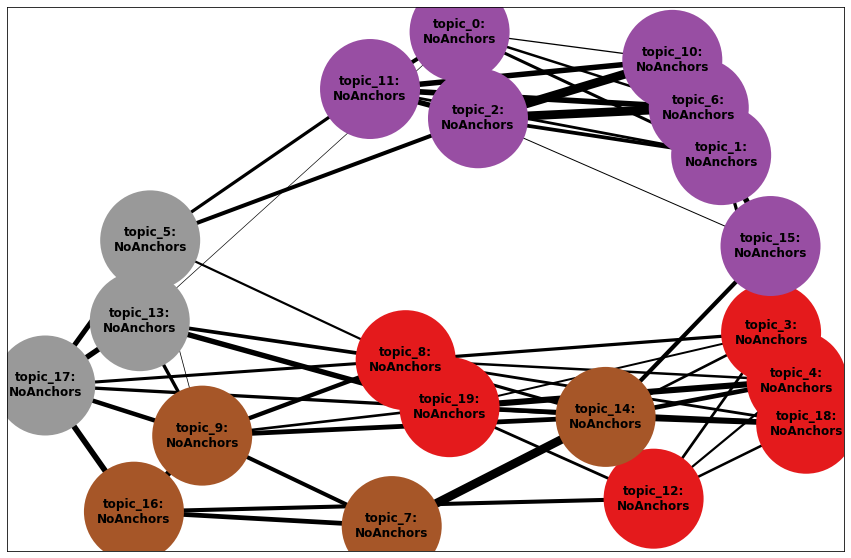

In [6]:
from community import community_louvain
import matplotlib.cm as cm

font_size=12
k = 0.1
node_size=10000
fig_size = (15,10)

pos = nx.spring_layout(G, seed=5, k=k) 

# labeldict = {topic: topic_keywords[topic][0:50].replace(',', '\n') for topic in G.nodes()}
labeldict = {topic: topic + ":\n" + s_anchor[topic].replace(' ', '\n') for topic in G.nodes()}

linewidths = [0 if s_anchor[topic] == 'NoAnchors' else 5 for topic in G.nodes()]

plt.figure(3,figsize=fig_size) 

# elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
edgewidth = [ d['weight'] for (u,v,d) in G.edges(data=True)]


partition = community_louvain.best_partition(G, resolution = 1)

print('Number Partitions ' + str(list(set(partition.values()))))

cmap = cm.get_cmap('Set1', max(partition.values())+1 )

nx.draw_networkx_nodes(G, pos, node_color=list(partition.values()), cmap = cmap, node_size=node_size, linewidths=linewidths, edgecolors='black')

nx.draw_networkx_edges(G, pos, edge_color='black', width=edgewidth)

nx.draw_networkx_labels(G, pos, font_size=font_size, font_family="sans-serif", labels = labeldict)

plt.show() 

In [14]:
df_table = pd.DataFrame(index= G.nodes)




#Topic names will not be sorted in table as strings...
df_table['topic'] = [int(topicstr.split('topic_')[1]) for topicstr in G.nodes]

# df_table['fill_color'] = fill_colors

# df_table = pd.concat([df_table, s_anchor], axis = 1)
df_table['anchor words'] = s_anchor
df_table['keywords'] = topic_keywords

topic_part = pd.Series(list(partition.values()), index= G.nodes)
df_table['partition'] = topic_part
df_table = df_table.sort_values('partition')

partitions_sorted = df_table['partition'].values

df_table = df_table.drop('partition', axis=1)


df_table = df_table.drop('topic', axis=1)
# df_table = df_table.set_index('topic')

# df_table

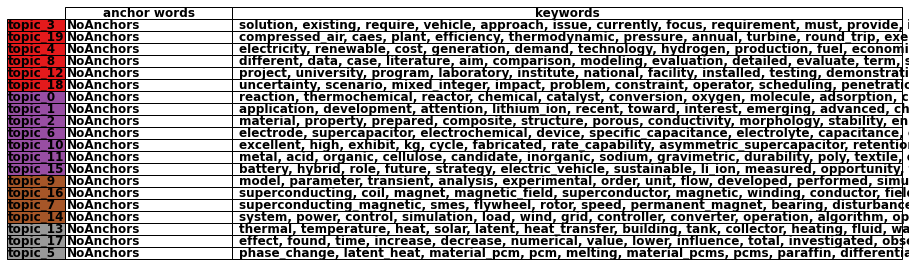

In [15]:
fig = plt.figure()

gs= fig.add_gridspec(1,1)

ax_tab = fig.add_subplot(gs[0,:], frame_on=False)
ax_tab.xaxis.set_visible(False)
ax_tab.yaxis.set_visible(False)

colors = cmap(list(partitions_sorted))

tab = pd.plotting.table(ax_tab, df_table, loc='center', rowColours=colors, colWidths = [0.5,2],cellLoc='left')

for key,cell in tab.get_celld().items():
    # if key[1]==0:                   
    cell.PAD = 0.01

tab.auto_set_font_size(False)
tab.set_fontsize(12)

# fig.tight_layout()